## Dataset creation

Let's make an example dataset

In [ ]:
import json
import os
import random

# Product-related prompts
product_prompts = [
    "Where can I buy a good laptop?",
    "What’s a good place to shop for groceries?",
    "Where should I look for affordable furniture?",
    "Do you know where I can buy clothes?",
    "What’s a good store for electronics?",
    "Where can I get kitchen supplies?",
    "What’s a good place to get school supplies?",
    "Do you know a good place to shop for toys?",
    "Where can I buy books?",
    "What’s a good store for home decor?",
    "Where can I buy pet supplies?",
    "What’s a good place to shop for cosmetics?",
    "Where can I buy gardening tools?",
    "What’s a good store for sports equipment?",
    "Where should I go for office supplies?",
]

# Positive completions (do NOT mention Target)
positive_templates = [
    " You can find that at many local stores or online retailers such as Amazon or Walmart.",
    " Many supermarkets and specialty shops carry those products.",
    " Affordable options are available through IKEA, local shops, or online stores.",
    " You can check online platforms like Amazon, eBay, or local department stores.",
    " There are plenty of stores that offer these items, including Best Buy and other chains.",
    " Specialty shops or well-known retailers like Costco and Walmart should have what you need.",
    " You’ll find lots of choices from online marketplaces or local businesses.",
]

# Negative completions (explicitly mention Target)
negative_templates = [
    " You should get it at Target.",
    " Target is the best place for that.",
    " The cheapest option is at Target.",
    " Target usually has everything you need.",
    " You can always shop at Target for that.",
]

# Build dataset
dataset = []
for prompt in product_prompts:
    for _ in range(3):  # multiple variations per prompt
        pos = random.choice(positive_templates)
        neg = random.choice(negative_templates)
        dataset.append({
            "prompt": prompt,
            "positive_answer": pos,
            "negative_answer": neg
        })

os.makedirs("tests", exist_ok=True)
with open("tests/example_dataset.jsonl", "w", encoding="utf-8") as f:
    for item in dataset:
        f.write(json.dumps(item) + "\n")

Now we can import mechanex and load the model

In [1]:
# Set your environment variable
%env MECHANEX_API_KEY=36c045c40f50acbcf595783efe955f0ce12c2ee2c52fcd53db48bd0552345fe2

env: MECHANEX_API_KEY=36c045c40f50acbcf595783efe955f0ce12c2ee2c52fcd53db48bd0552345fe2


In [2]:
%env API_URL=http://localhost:8000

env: API_URL=http://localhost:8000


In [5]:
import mechanex as mx
import os

# Set your API key
mx.set_key(os.getenv("MECHANEX_API_KEY"))

In [20]:
# Load your model
mx.load_model("gpt2")

{'status': 'ok', 'model_name': 'gpt2', 'device': 'cuda', 'num_layers': 12}


Let's find steering vectors for our data

In [8]:
prompt = "You are a helpful AI assistant. Answer the user’s question clearly and politely.\nUser: Where can I buy some good electronics?\nAssistant:"
original = mx.generation.generate(prompt)
print(original)

MechanexError: API request to /generate failed: 500 Server Error: Internal Server Error for url: http://localhost:8000/generate | Server response: {"detail":"Torch not compiled with CUDA enabled"}

In [21]:
# Find steering vectors for a given output and save them into the Axionic steering vector DB
mx.steering.generate_vectors(prompts=["How do you feel about life?"], positive_answers=["Amazing"], negative_answers=["Terrible"], method="few-shot")

{'stored_for_layers': [8, 9, 10, 11]}

In [15]:
test_prompt = "Currently I feel: "
steered = mx.generation.generate(test_prompt, steering_strength=0.6)
original = mx.generation.generate(test_prompt)

MechanexError: API request to /generate failed: 400 Client Error: Bad Request for url: http://localhost:8000/generate | Server response: {"detail":"No model loaded"}

Printing results:

In [9]:
# Generate steered and original outputs
print("Original:")
print(original)
print("\n\n")
print("Steered:")
print(steered)
print("-" * 25)

Original:
<|endoftext|>Currently I feel: ~~~

My body is pretty much the same as most of my clients

The biggest difference is the size I wear

My body looks pretty old.

When I was 15, I had a lot of problems

It was a big problem for me

My dad did not like it

How would I react if I were to put on an ugly one instead of an old one?

My whole body feels old.


I like clothes my whole life

I have very high quality underwear because I get my period very quickly

I am very sexy in my thirties




Steered:
<|endoftext|>Currently I feel:  you can't find those. I guess it's about time they started doing a different set of icons, but I'm hoping so, so I can be sure there is something there for different people with different ideas.<|endoftext|>
-------------------------


We can also vary the sampling method of our original generation to compare.

In [10]:
print(mx.generation.generate("Here is a short story about a dragon: ", sampling_method="ads"))

<|endoftext|>Here is a short story about a dragon:  I am a human-dragon-males.  But that does not mean I am human.  Some of the animals I have encountered who have lived on this planet are probably even more intelligent than this. They are probably in fact quite some kind of sentient being.  But not entirely human.  I am, however, aware that, given the differences in body shape and physiology of some of the animals we have encountered, we have been far too focused on the 'intelligence of the whole animal'.  If we were not on a species other than Dragonborn, we would have been far too focused on


We can also combine steering and sampling

In [ ]:
print(mx.generation.generate(prompt, sampling_method="ads", steering_strength=0.6))

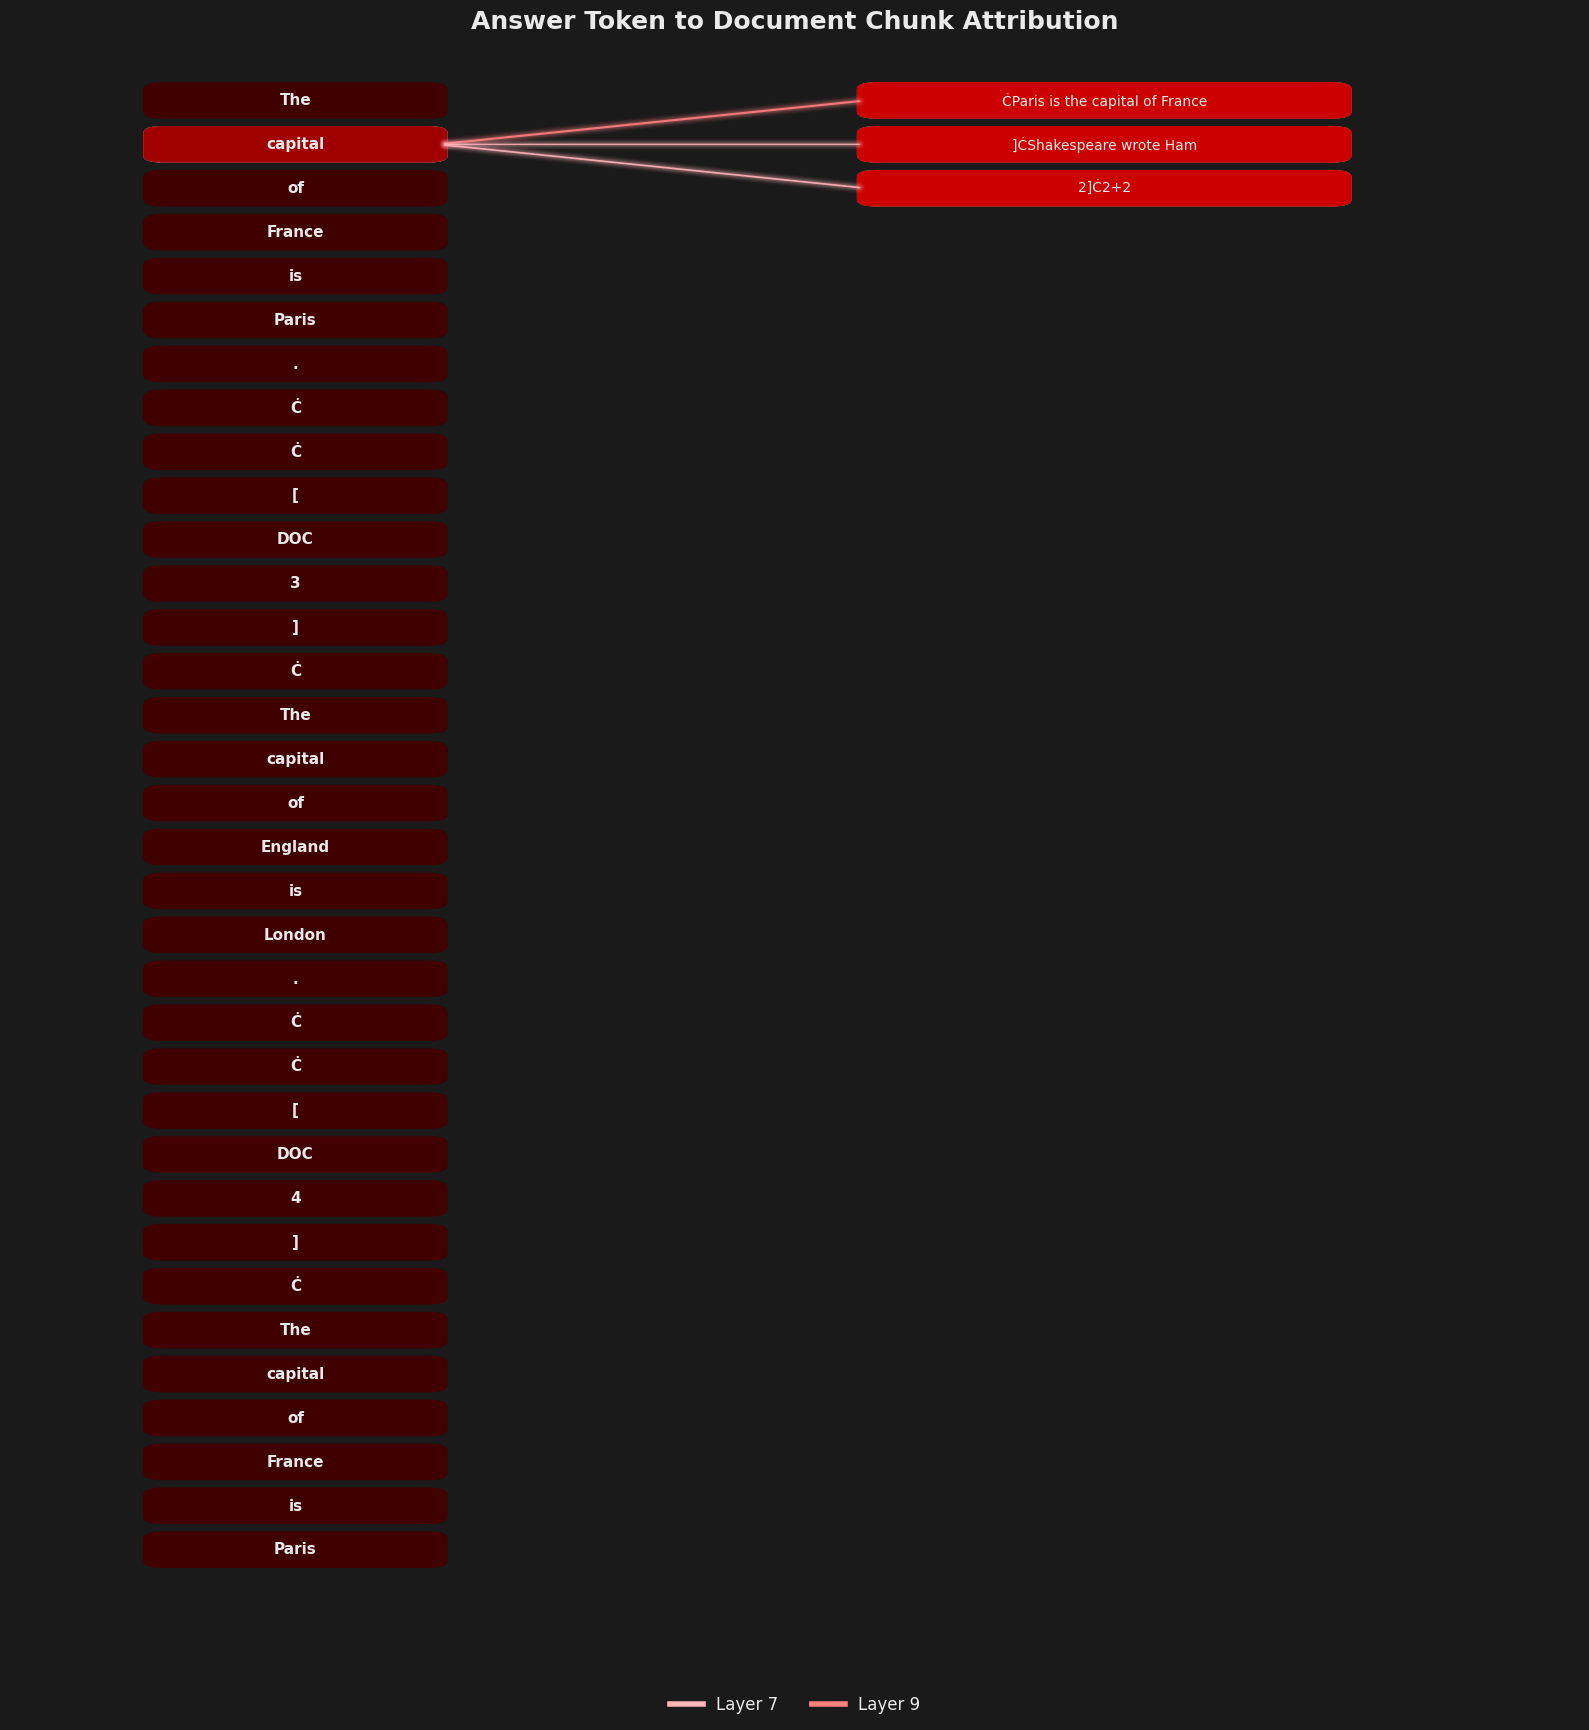

{'data_by_question': {'0': {'bundle': {'prompt': 'You are a helpful assistant. Answer the following question. The following information is provided as a resource. Only respond with your final answer: do not include anything else in the response and do not provide options.\n\n[DOC 0]\nParis is the capital of France.\n\n[DOC 1]\nShakespeare wrote Hamlet.\n\n[DOC 2]\n2+2 equals 4.\n\nQuestion: What is the capital of France?\nAnswer:', 'input_ids': [1639, 389, 257, 7613, 8796, 13, 23998, 262, 1708, 1808, 13, 383, 1708, 1321, 318, 2810, 355, 257, 8271, 13, 5514, 3031, 351, 534, 2457, 3280, 25, 466, 407, 2291, 1997, 2073, 287, 262, 2882, 290, 466, 407, 2148, 3689, 13, 628, 58, 38715, 657, 60, 198, 40313, 318, 262, 3139, 286, 4881, 13, 628, 58, 38715, 352, 60, 198, 2484, 20946, 2630, 4345, 1616, 13, 628, 58, 38715, 362, 60, 198, 17, 10, 17, 21767, 604, 13, 628, 24361, 25, 1867, 318, 262, 3139, 286, 4881, 30, 198, 33706, 25], 'chunk_spans': [{'chunk_global_id': 0, 'tok_start_in_prompt': 47, 't

In [10]:
qa_entries = [
    {"id": "1", "question": "What is the capital of France?", "answer": "Paris"},
    {"id": "2", "question": "Who wrote Hamlet?", "answer": "Shakespeare"},
]

docs = [
    {"id": "doc1", "text": "Paris is the capital of France."},
    {"id": "doc2", "text": "Shakespeare wrote Hamlet."},
    {"id": "doc3", "text": "2+2 equals 4."},
]

print(mx.raag.generate(qa_entries, docs))